In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [2]:

from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize
from accelerate import Accelerator

import wandb
import itertools
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
from safetensors.torch import load_file
from einops import rearrange
from sklearn.manifold import TSNE
import timeit
from PIL import Image
import numpy as np
import cv2
import os

import lovely_tensors as lt
lt.monkey_patch()

from label_anything.models import build_lam_no_vit
from label_anything.experiment.substitution import Substitutor
from label_anything.data.examples import uniform_sampling
from label_anything.data import utils
from label_anything.data.utils import AnnFileKeys, PromptType, BatchKeys

Helper functions

In [3]:
def to_device(batch, device):
    if isinstance(batch, (list, tuple)):
        return [to_device(b, device) for b in batch]
    if isinstance(batch, dict):
        return {k: to_device(v, device) for k, v in batch.items()}
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    return batch

def obtain_batch(superdatset, dataset, images, image_ids, cat_ids, classes, img_sizes, image_key, prompts, ground_truths=None):
    bboxes, masks, points = prompts
    # obtain padded tensors
    bboxes, flag_bboxes = dataset.annotations_to_tensor(
        bboxes, img_sizes, PromptType.BBOX
    )
    masks, flag_masks = dataset.annotations_to_tensor(
        masks, img_sizes, PromptType.MASK
    )
    points, flag_points = dataset.annotations_to_tensor(
        points, img_sizes, PromptType.POINT
    )

    # obtain ground truths
    if ground_truths is None:
        ground_truths = dataset.compute_ground_truths(image_ids, cat_ids)

    # stack ground truths
    dims = torch.tensor(img_sizes)
    max_dims = torch.max(dims, 0).values.tolist()
    ground_truths = torch.stack(
        [utils.collate_gts(x, max_dims) for x in ground_truths]
    )

    if dataset.load_gts:
        # convert the ground truths to the right format
        # by assigning 0 to n-1 to the classes
        ground_truths_copy = ground_truths.clone()
        # set ground_truths to all 0s
        ground_truths = torch.zeros_like(ground_truths)
        for i, cat_id in enumerate(cat_ids):
            if cat_id == -1:
                continue
            ground_truths[ground_truths_copy == cat_id] = i

    data_dict = {
        image_key: images,
        BatchKeys.PROMPT_MASKS: masks,
        BatchKeys.FLAG_MASKS: flag_masks,
        BatchKeys.PROMPT_POINTS: points,
        BatchKeys.FLAG_POINTS: flag_points,
        BatchKeys.PROMPT_BBOXES: bboxes,
        BatchKeys.FLAG_BBOXES: flag_bboxes,
        BatchKeys.DIMS: dims,
        BatchKeys.CLASSES: classes,
        BatchKeys.IMAGE_IDS: image_ids,
        BatchKeys.GROUND_TRUTHS: ground_truths,
    }
    batch = superdatset.collate_fn([(data_dict, "coco")])
    return batch

In [4]:
def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.cpu().numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [5]:
def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

In [6]:
def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.cpu().numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

In [7]:
def draw_seg(img: Image, seg: torch.Tensor, colors, num_classes):
    resized_image = resize(img.copy(), seg.shape[-2:])
    masked_image = resized_image.copy()
    for i in range(1, num_classes):
        binary_mask = (seg == i)[0]
        mask = binary_mask.cpu().numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resized_image), 0.6, masked_image, 0.4, 0)

In [8]:
def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

In [9]:
def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

In [10]:
def plot_images(images, classes, ids_to_cats):
    num_images = len(images)
    cols = 2
    rows = (num_images + 1) // cols

    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    for i, img in enumerate(images):
        cats = [ids_to_cats[cat]["name"] for cat in classes[i]]
        if rows == 1:
            ax[i % cols].imshow(img)
            ax[i % cols].set_title(", ".join(cats))
            ax[i % cols].axis("off")
        else:
            ax[i // cols, i % cols].imshow(img)
            ax[i // cols, i % cols].set_title(", ".join(cats))
            ax[i // cols, i % cols].axis("off")
        
    plt.show()

def plot_all(dataset, batch, colors):
    unbatched = {k : v[0] for k, v in batch.items()}
    images = [
    draw_all(
        get_image(unbatched["images"][i]),
        unbatched["prompt_masks"][i],
        unbatched["prompt_bboxes"][i],
        unbatched["prompt_points"][i],
        colors
    )
    for i in range(unbatched["images"].shape[0])
]
    plot_images(images, unbatched["classes"], dataset.categories["coco"])

In [11]:
def plot_segs(seg, gt, colors):
    num_classes = len(input['classes'][0][0]) + 1
    image = get_image(input['images'][0, 0])
    segmask = draw_seg(
        image,
        seg.cpu(),
        colors,
        num_classes=num_classes
    )

    gtmask = draw_seg(
        image,
        gt,
        colors,
        num_classes=num_classes
    )
    blank_seg = Image.fromarray(np.zeros_like(segmask))
    blank_gt = Image.fromarray(np.zeros_like(gtmask))
    blank_segmask = draw_seg(
        blank_seg,
        seg.cpu(),
        colors,
        num_classes=num_classes
    )

    blank_gtmask = draw_seg(
        blank_gt,
        gt,
        colors,
        num_classes=num_classes
    )
    plots = [segmask, gtmask, blank_segmask, blank_gtmask, image, image]
    titles = ["Predicted", "Ground Truth", "Predicted", "Ground Truth", "Original", "Original"]

    subplots = plt.subplots(3, 2, figsize=(20, 30))
    for i, (plot, title) in enumerate(zip(plots, titles)):
        subplots[1].flatten()[i].imshow(plot)
        subplots[1].flatten()[i].set_title(title)
        subplots[1].flatten()[i].axis("off")

In [12]:
def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

In [13]:
def load_checkpoint(accelerator, run_id):
    api = wandb.Api()
    run = api.run(f"cilabuniba/LabelAnything/{run_id}")
    files = run.files()
    model_file = None
    for file in files:
        if "model" in file.name and "best" in file.name:
            model_file = file.download(replace=True)
    accelerator.load_state("best")

In [14]:
def get_embeddings_names(batch):
    image_ids = batch['image_ids']
    z_filled = [[str(image_id).zfill(12) for image_id in item] for item in image_ids]
    flattened = [item for sublist in z_filled for item in sublist]
    # filter embeddings already present in EMBEDDINGS_DIR
    filtered = [item for item in flattened if not Path(f"{EMBEDDINGS_DIR}/{item}.safetensors").exists()]
    print(" ".join(filtered))
    
def set_embeddings(accelerator, batch):
    item = batch['image_ids'][0]
    safetensors = []
    for id in item:
        safetensors.append(load_file(f"{EMBEDDINGS_DIR}/{str(id).zfill(12)}.safetensors")['embedding'])
        
    safetensors = torch.stack(safetensors).unsqueeze(0)
    safetensors = safetensors.to(accelerator.device)
    batch['embeddings'] = safetensors
    return batch

In [15]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]

text_colors = [
    "blue",
    "red",
    "green",
    "yellow",
    "purple",
    "cyan",
    "orange",
    "pink",
    "brown",
    "grey",
    "black"
]

In [16]:
pdir = Path.cwd().parent

Dataset definition

In [17]:
IMG_DIR = "/ext/stalla/LabelAnything/images/train2017"
ANNOTATIONS_DIR = os.path.join(pdir, "data/annotations/instances_val2017.json")
EMBEDDINGS_DIR = "/ext/stalla/LabelAnything/embeddings"


In [18]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [19]:
dataset = LabelAnythingDataset(
    {
        "coco": {
            "name": "coco",
            "instances_path": ANNOTATIONS_DIR,
            "img_dir": IMG_DIR,
            "preprocess": preprocess,
        }
    }, {}
)
coco_dataset = dataset.datasets["coco"]
accelerator = Accelerator()
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 8], [1, 4], [1, 2], [1, 1]],
        num_processes=1,
        shuffle=False,
)
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)
dataloader = accelerator.prepare(dataloader)
iter_data = iter(dataloader)

Loading dataset annotations from /home/pasquale/projects/LabelAnything/data/annotations/instances_val2017.json...


---
Load model

In [20]:
model = build_lam_no_vit(
    spatial_convs=3,
)
model = accelerator.prepare(model)

Load weights

In [21]:
run_id = "gjdpcfya"
load_checkpoint(accelerator, run_id)

[2024-02-10 18:58:41] INFO - logging.py - Loading states from best
[2024-02-10 18:58:41] INFO - logging.py - All model weights loaded successfully
[2024-02-10 18:58:41] INFO - logging.py - All optimizer states loaded successfully
[2024-02-10 18:58:41] INFO - logging.py - All scheduler states loaded successfully
[2024-02-10 18:58:41] INFO - logging.py - All dataloader sampler states loaded successfully
[2024-02-10 18:58:41] INFO - logging.py - Could not load random states
[2024-02-10 18:58:41] INFO - logging.py - Loading in 0 custom states


---

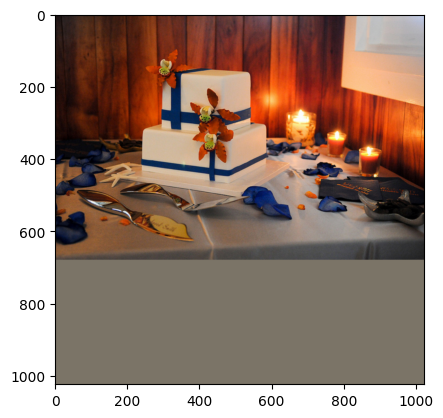

In [22]:
idx = 80
num_examples = 8
base_image_data = coco_dataset.images[coco_dataset.image_ids[idx]]

fig = plt.imshow(get_image(coco_dataset._load_and_preprocess_image(base_image_data)))

In [23]:
img_cats = torch.tensor(list(coco_dataset.img2cat[base_image_data[AnnFileKeys.ID]]))
sampled_classes = (
    coco_dataset.example_generator.sample_classes_from_query(img_cats, uniform_sampling)
    if coco_dataset.do_subsample
    else img_cats
)
toggle_classes = {
    widgets.ToggleButton(description=coco_dataset.categories[cat.item()]["name"], value=True): cat for cat in img_cats
}
row_classes = widgets.HBox(list(toggle_classes.keys()))
display(row_classes)

In [24]:
sampled_classes = [cat for toggle, cat in toggle_classes.items() if toggle.value]
print([coco_dataset.categories[cat.item()]["name"] for cat in sampled_classes])

['knife', 'dining table', 'cake', 'cup']


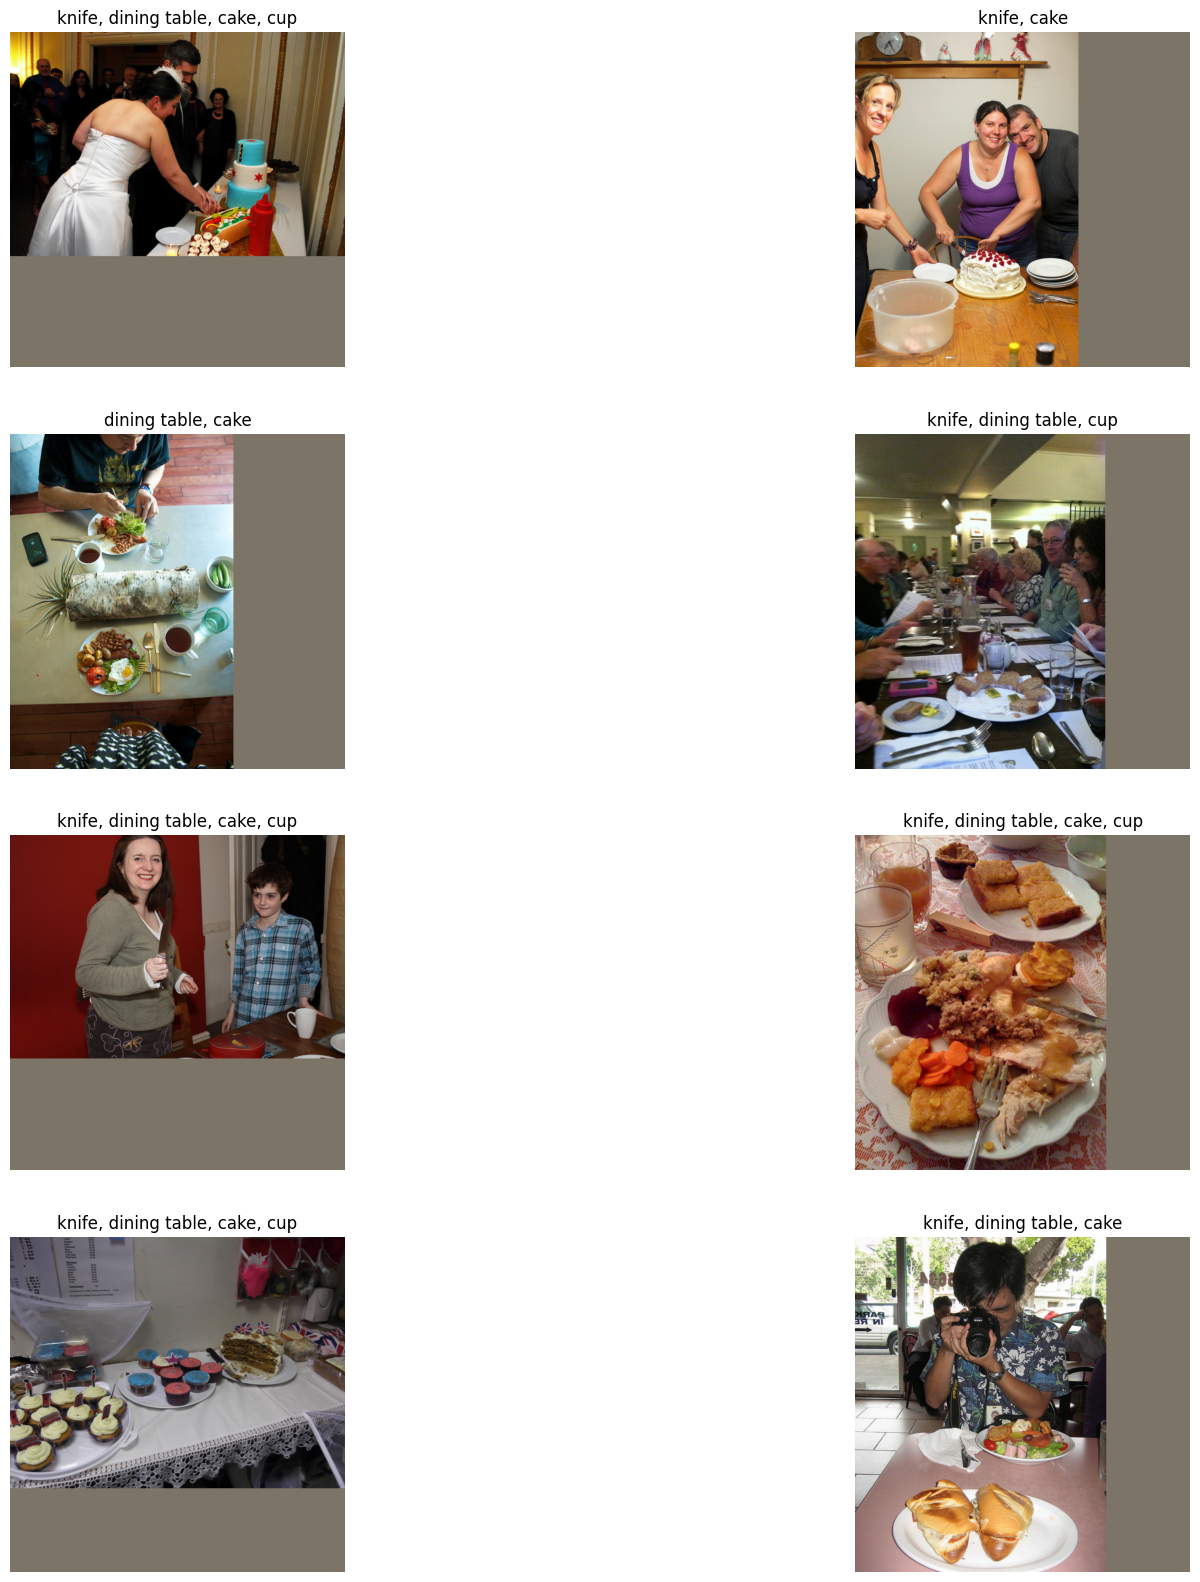

In [25]:
image_ids, aux_cat_ids =  coco_dataset.example_generator.generate_examples(
    query_image_id=base_image_data[AnnFileKeys.ID],
    image_classes=img_cats,
    sampled_classes=torch.tensor(sampled_classes),
    num_examples=num_examples,
)

cat_ids = list(set(itertools.chain(*aux_cat_ids)))
cat_ids.insert(0, -1)  # add the background class

images, image_key, ground_truths = coco_dataset._get_images_or_embeddings(image_ids)

pil_images = [get_image(image) for image in images][1:]

plot_images(pil_images, aux_cat_ids, coco_dataset.categories)

In [26]:
options = {PromptType.BBOX, PromptType.MASK, PromptType.POINT}
toggle_prompts = {widgets.ToggleButton(description=option, value=True): option for option in options}
buttons_row = widgets.HBox(list(toggle_prompts.keys()))
display(buttons_row)

In [27]:
prompt_types = [option for toggle, option in toggle_prompts.items() if toggle.value]
print(prompt_types)

[<PromptType.POINT: 'point'>, <PromptType.MASK: 'mask'>, <PromptType.BBOX: 'bbox'>]


In [28]:
bboxes, masks, points, classes, img_sizes = coco_dataset._get_prompts(
    image_ids, cat_ids, prompt_types
)

In [29]:
(batch, gt), dataset_name = obtain_batch(dataset, coco_dataset, images, image_ids, cat_ids, classes, img_sizes, image_key, (bboxes, masks, points), ground_truths=None)

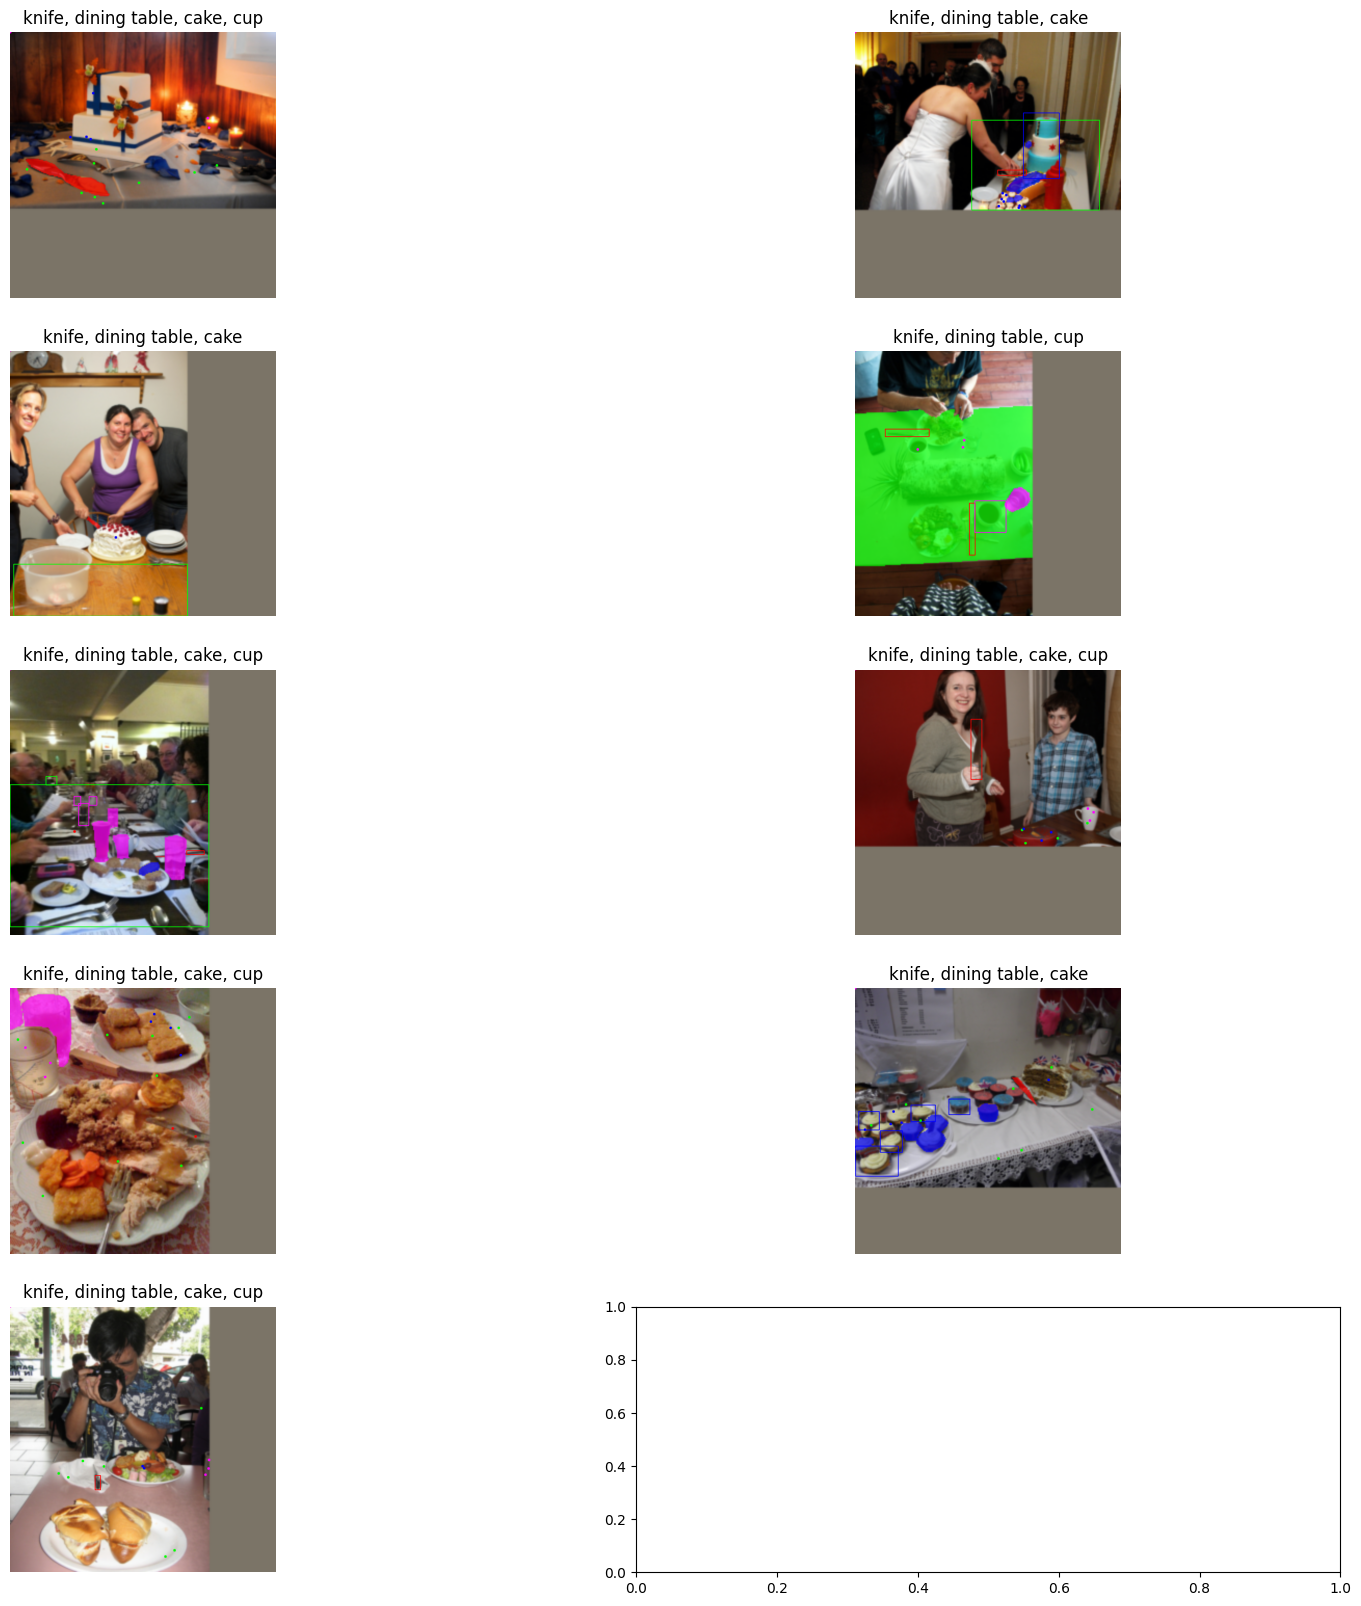

In [30]:
plot_all(dataset, batch, colors)

In [31]:
get_embeddings_names(batch)


000000173383 000000350679 000000568195 000000496571 000000376322 000000048396 000000419312 000000318455 000000350148


In [32]:
batch = set_embeddings(accelerator, batch)
batch = to_device(batch, accelerator.device)

 Load the substitutor

In [33]:
substitutor = Substitutor(substitute=False)
substitutor.reset((batch, gt))
input, one_gt = next(iter(substitutor))

In [34]:
seg = model(input)

In [36]:
logits = seg['logits']
examples_class_embeddings = seg['class_examples_embeddings']
class_embeddings = examples_class_embeddings.mean(dim=1)

seg = logits.argmax(dim=1)

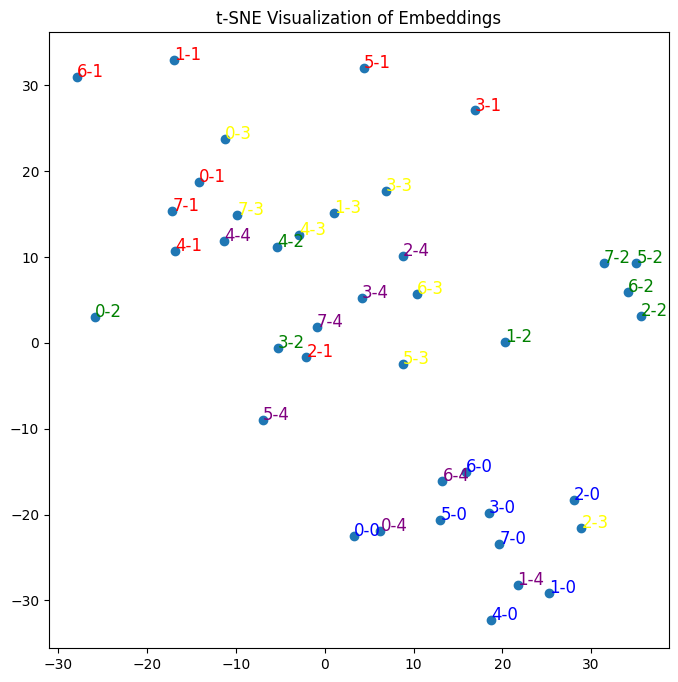

In [37]:
# Assuming you have a tensor `embeddings` with shape (16, 256)
# Replace this with your actual tensor
b, n, c, d = examples_class_embeddings.shape
embeddings = rearrange(examples_class_embeddings, 'b n c d -> (b n c) d')

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

# Plot the 2D embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate points with indices
embeddings_2d = embeddings_2d.reshape(b, n, c, 2)
for i in range(b):
    for j in range(n):
        for k in range(c):
            x, y = embeddings_2d[i, j, k]
            plt.text(x, y, f"{j}-{k}", color=text_colors[k], fontsize=12)

plt.title('t-SNE Visualization of Embeddings')
plt.show()


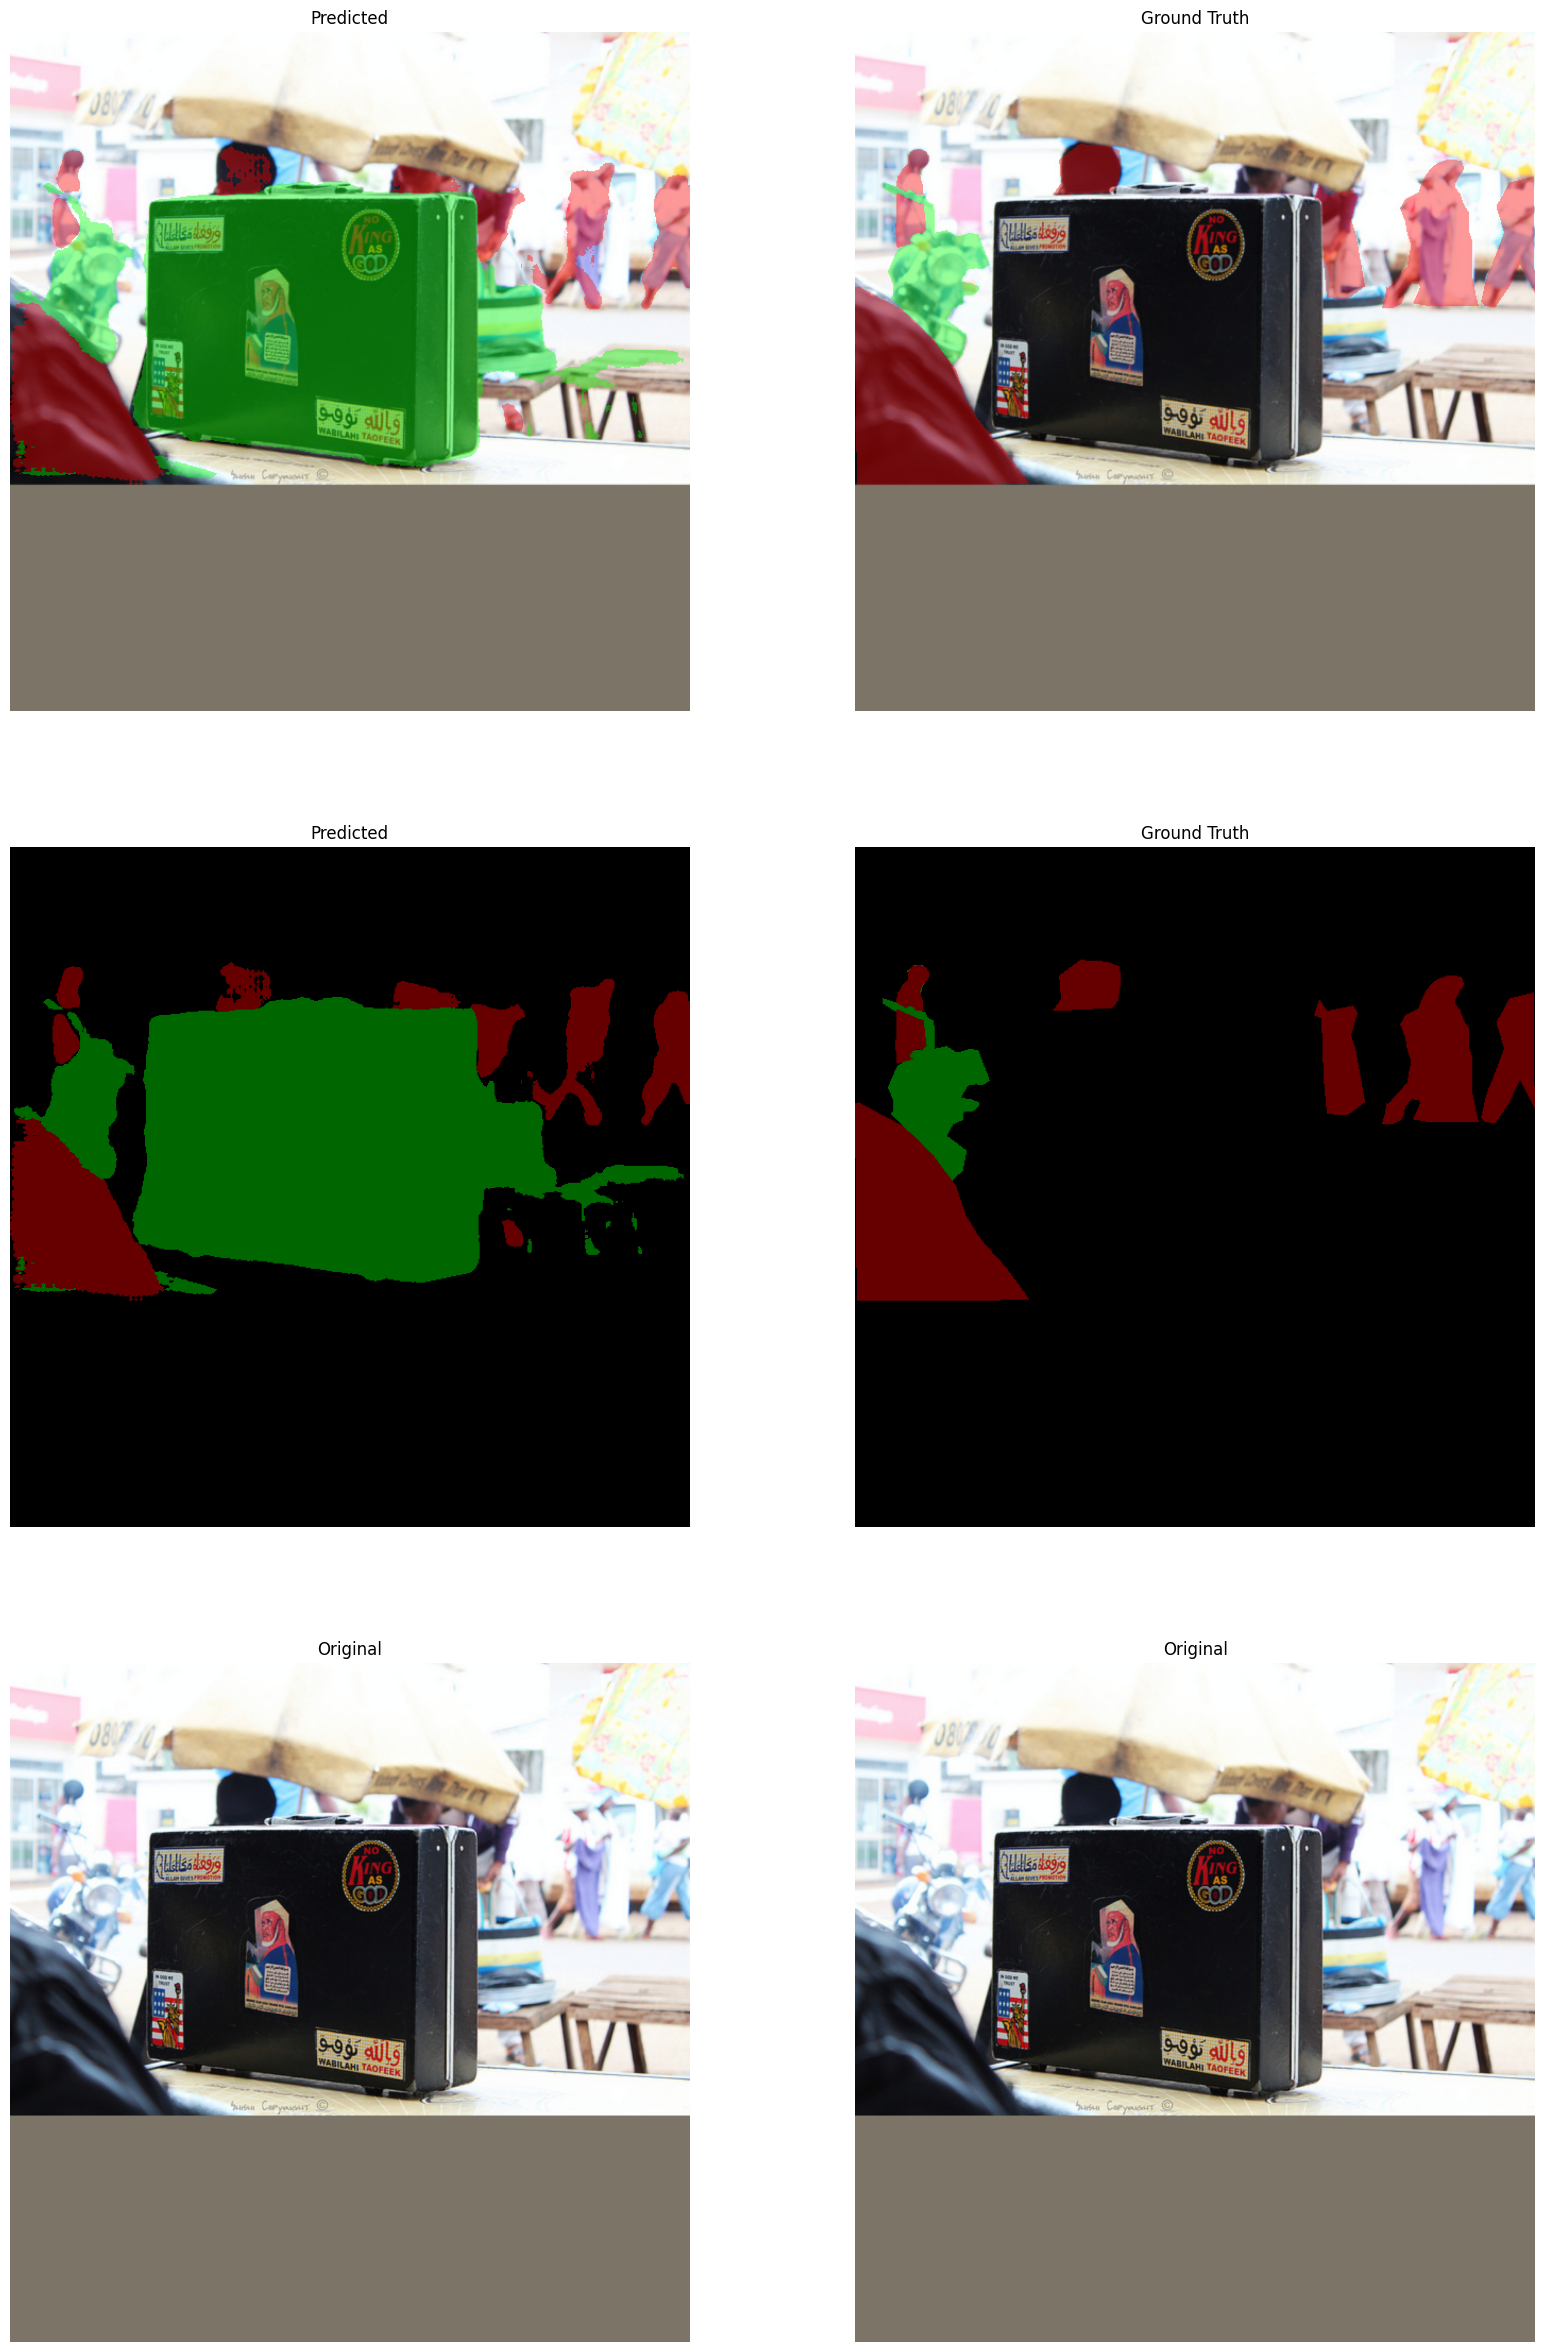

In [166]:
plot_segs(seg, one_gt, colors)

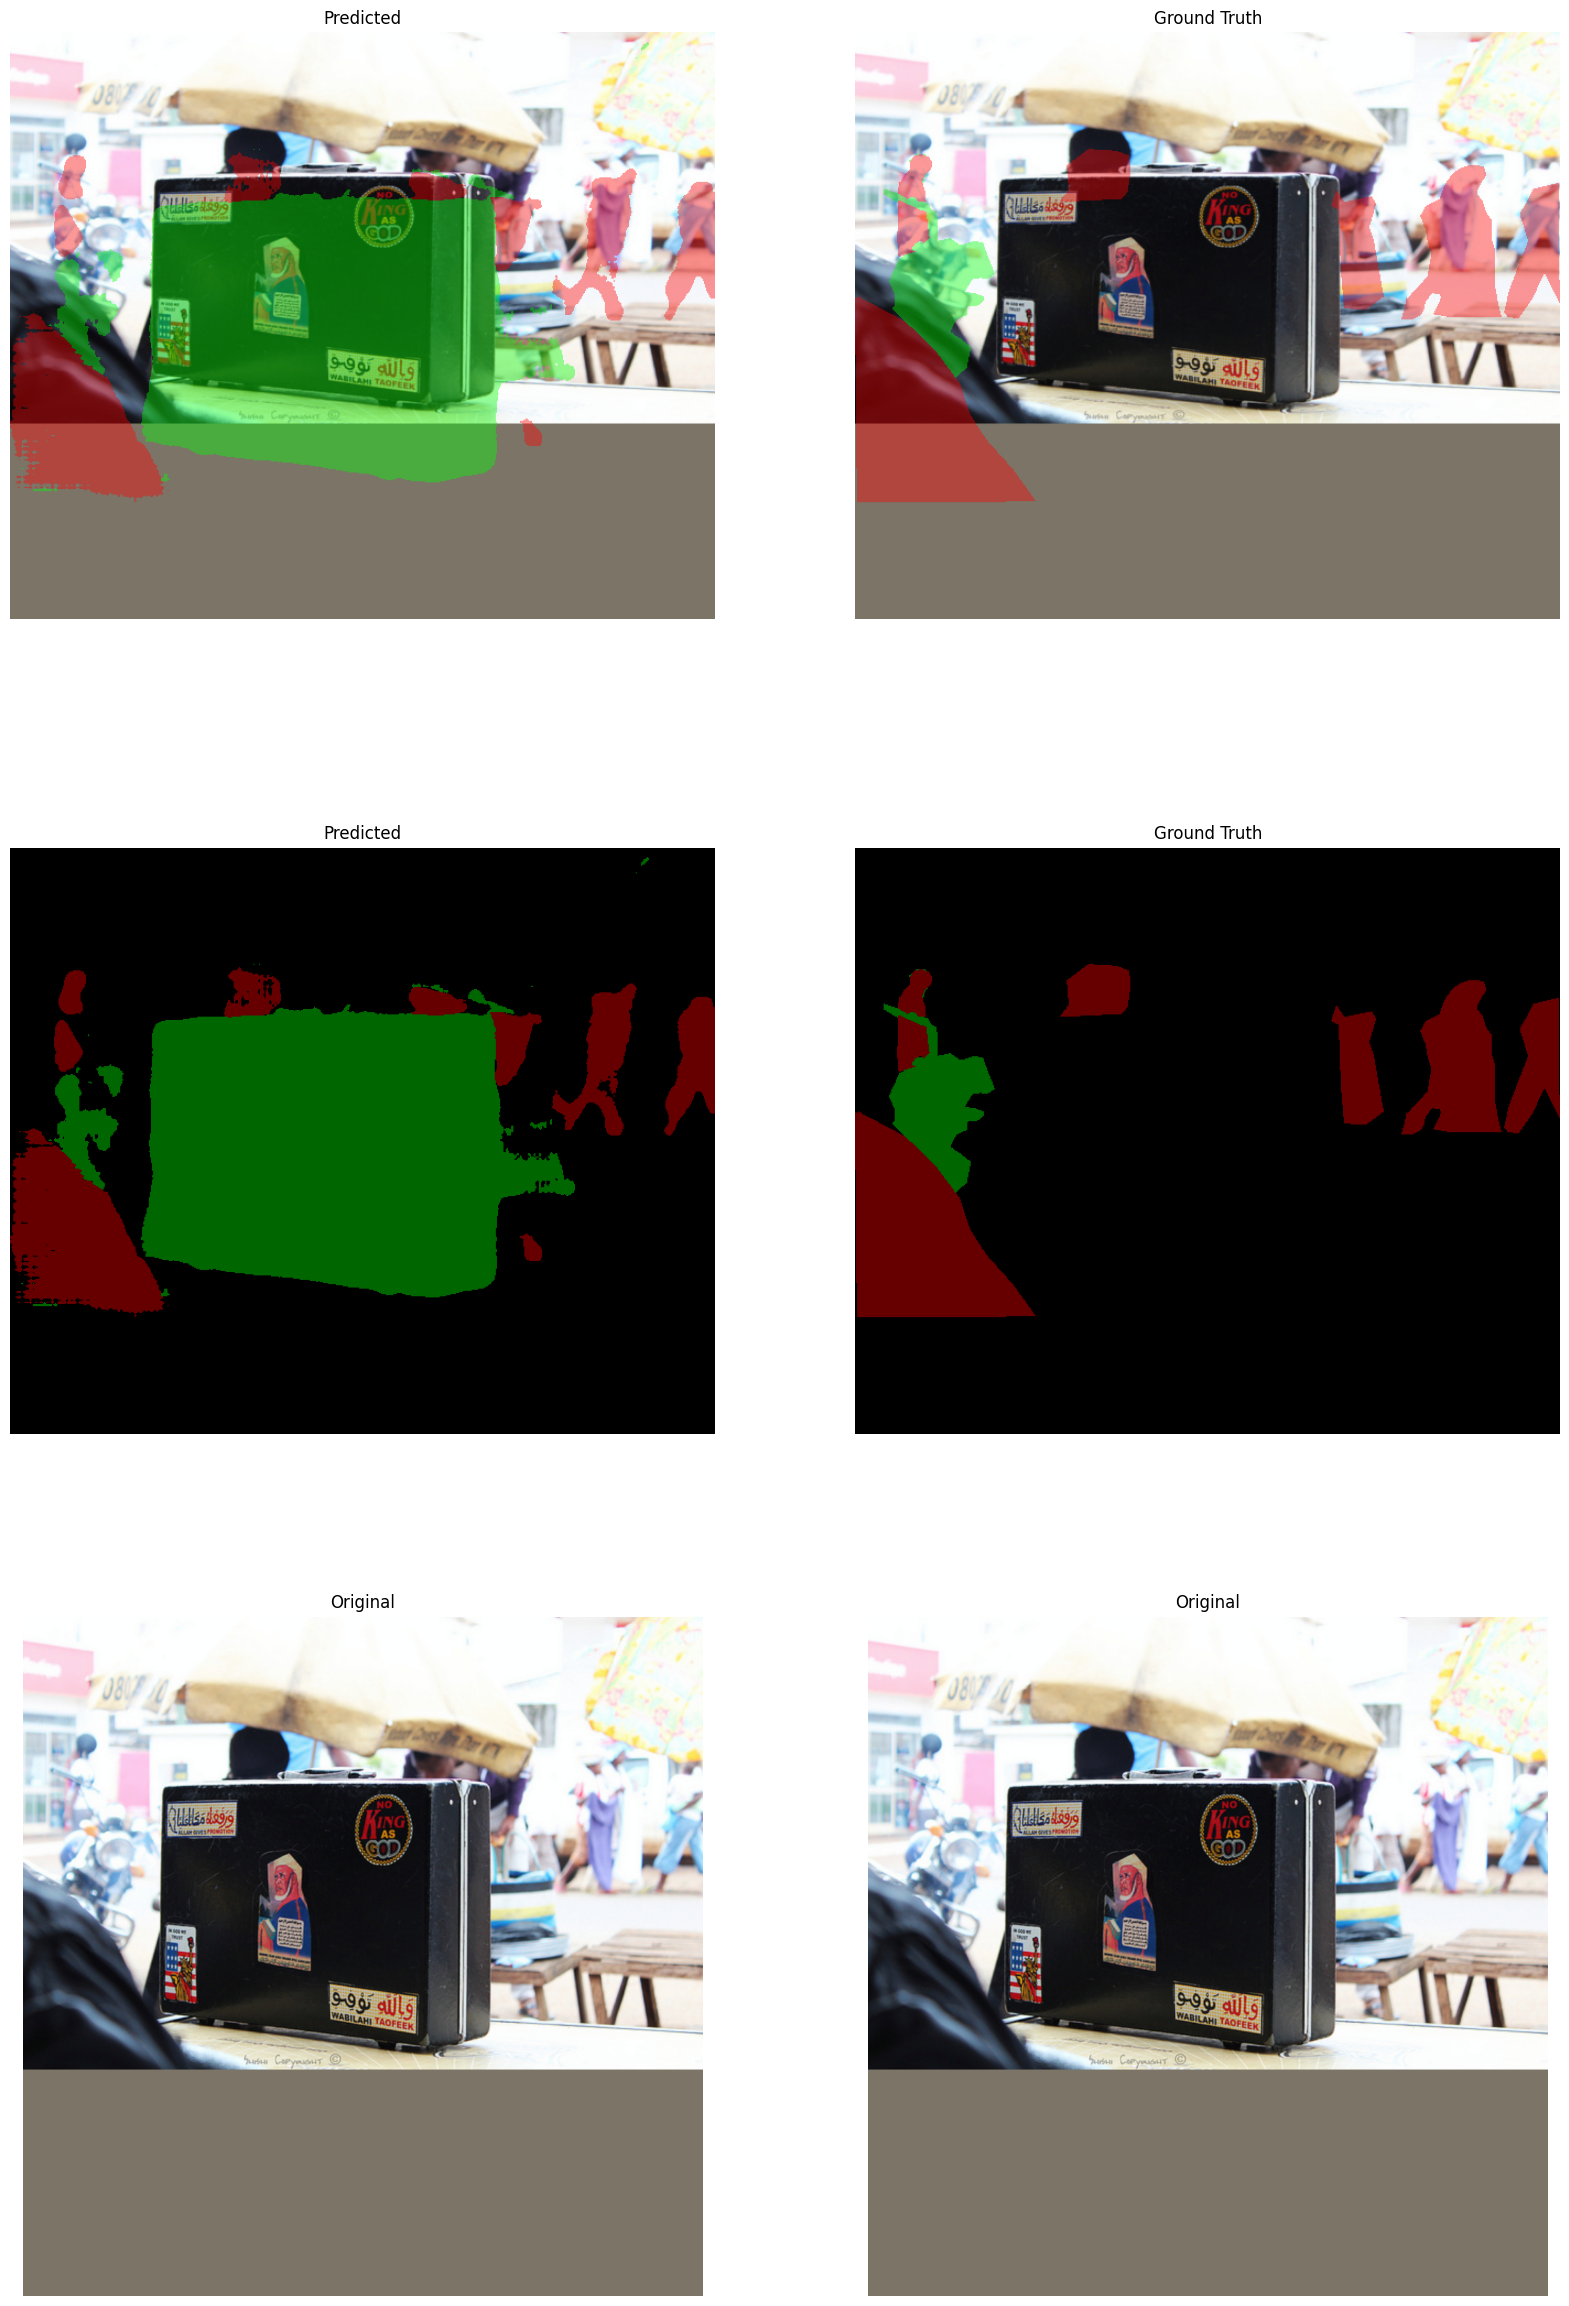

In [153]:
plot_segs(seg, one_gt, colors)